# Creating sediment input into Landlab NetworkSedimentTransporter component

#### This lab was created by graduate students as part of the 2021 CSDMS ESPIn (Earth Surface Processes Institute).**

#### Creators
Marius - 
Mel Guirro - Durham University
Muneer - VT
Se Jong -USGS 


For more Landlab tutorials, click here: https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html


## Notebook Overview

This notebook will...

### Learning Objectives
Topical learning objectives:
1. Fluvial sediment processes through  river network

### Landlab Components used

## Conceptual Model


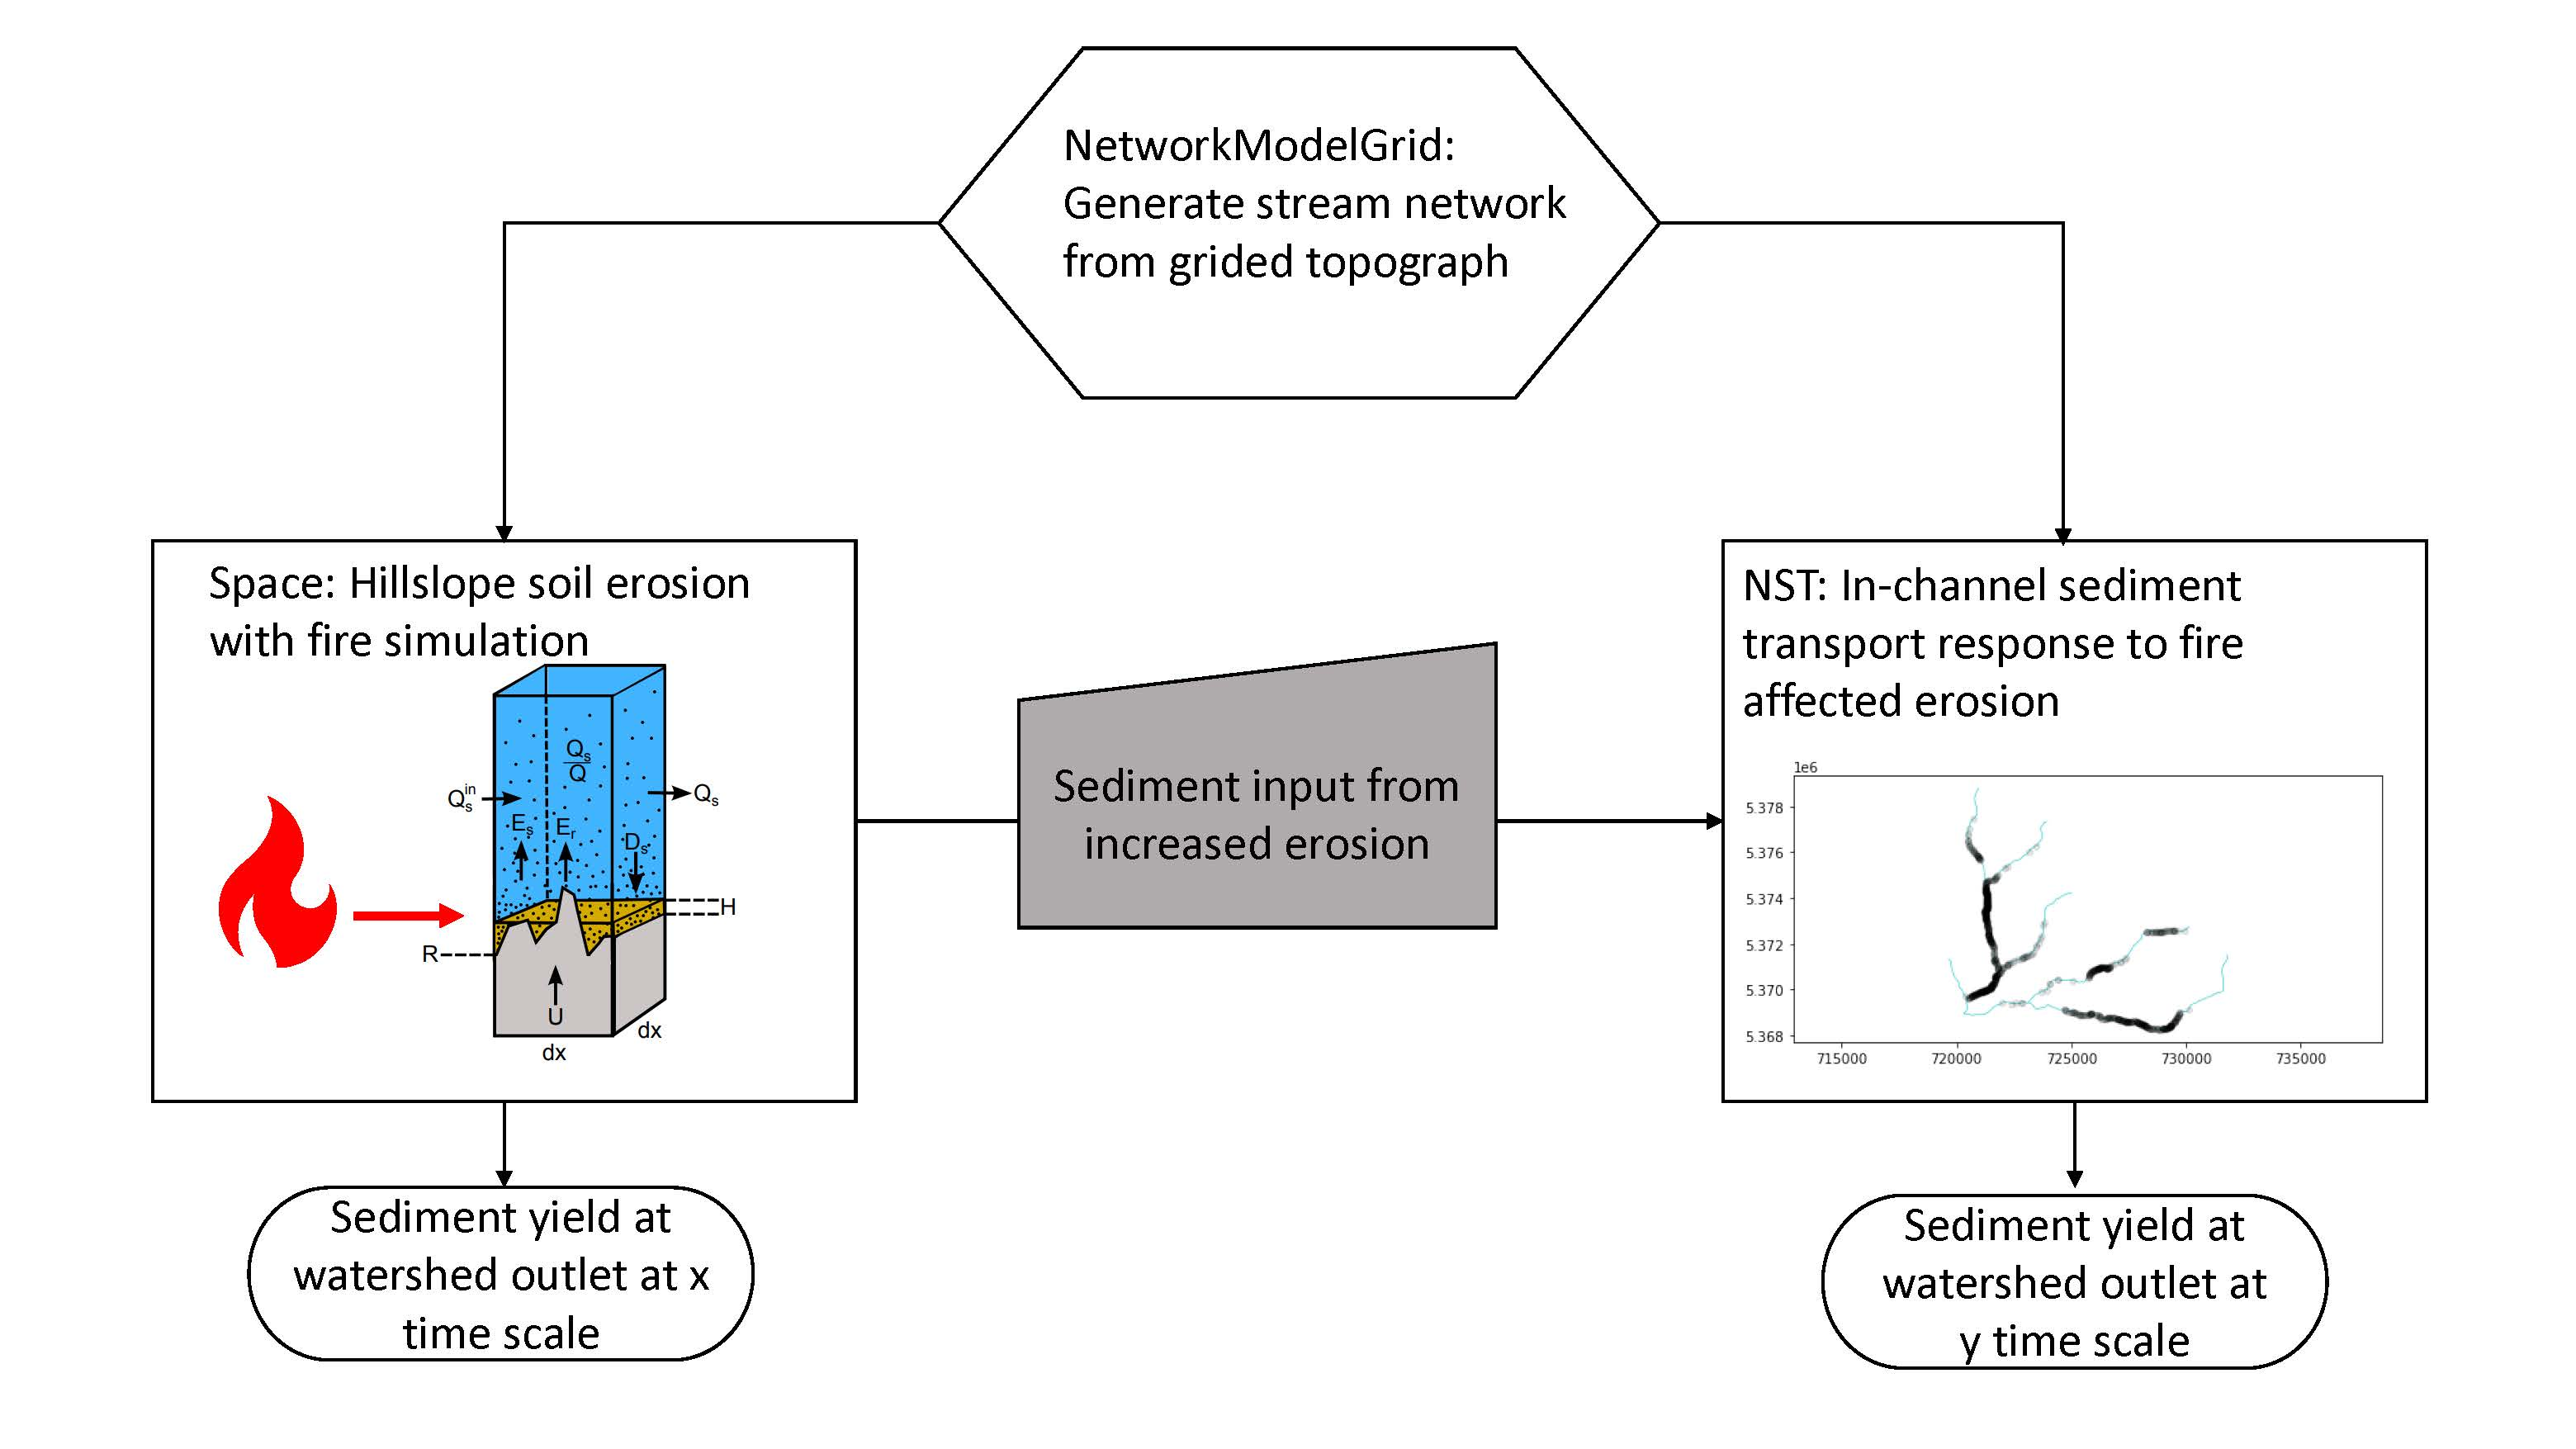

## Load the necessary packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.plot import plot_network_and_parcels

%matplotlib inline

## Create the river network model grid from landscape grid created from SPACE

In [3]:
#Fetch DEM ascii
tutorial_dir = os.path.dirname('C:\Users\scho\Documents\Espin_prj\slopes-channels') #NEED TO ENTER CORRECT DIRECTORY!!!
#raster_fn = os.path.join(tutorial_dir, 'overland_flow/hugo_site.asc') #mac
raster_fn = os.path.join(tutorial_dir, 'exampleDEM.asc') #windows

#define landcape grid
mg, z = read_esri_ascii(raster_fn, name='exampleDEM')
#rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
#rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED

#plot dem
plt.figure(figsize=(8,4))
imshow_grid(rmg, 'exampleDEM',
            plot_name="Basin topography",
            color_for_closed=None,
            colorbar_label="$z$ [m]")
plt.show()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-3-99ca1dcfd015>, line 2)

In [ ]:
#create channel network grid from landscape grid from <Space team: minimalSpaceExample.ipynb>

#THIS DOES NOT WORK BECAUE THE CHANNEL NETWORK GRID CREATED FROM create_network_from_raster DOES NOT PROVIDE NODE AND LINK FIELDS 
#DO NOT RUN: GO TO NEXT BLOCK FOR SIMPLE EXAMPLE OF NST WITH SIMULATED SEDIMENT PARCEL INCREASE

from create_network import create_network_from_raster
nmg = create_network_from_raster(
    mg,
    method='variable', # method
    n_widths=dx,
    #node_spacing=30,
    #d_node_spacing=2*dx,
    min_channel_thresh=30000,
    fields=['drainage_area', 'topographic__elevation'])

from landlab.plot import graph

## Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()

In [ ]:
#Create simple river network model grid
#each link is the reach of the river connected by nodes
y_of_node = (0, 100, 200, 200, 300, 400, 400, 125)
x_of_node = (0, 0, 100, -50, -100, 50, -150, -100)

nodes_at_link = ((1, 0), (2, 1), (1, 7), (3, 1), (3, 4), (4, 5), (4, 6))

grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

plt.figure(0)
graph.plot_graph(grid, at="node,link")

#Populate the grid with topographic information

grid.at_node["topographic__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]
grid.at_node["bedrock__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]

grid.at_link["flow_depth"] = 2.5 * np.ones(grid.number_of_links) # m
grid.at_link["reach_length"] = 200*np.ones(grid.number_of_links) # m
grid.at_link["channel_width"] = 1*np.ones(grid.number_of_links) # m

## Create sediment 'parcels' in a DataRecord

In [ ]:
#Here we synthetically introduce increased sediment availability from fire or landslide at adjacent nodes
#Muneer's sediment parcel magic: v=additional volumes of sediment at different links

v=[0,2,4,7,8,0,5] #total volm (m^3):  main expected INPUT for all links
uv=0.05; #trial unit parcel volm

l=np.arange(grid.number_of_links)

n=np.array(v)/uv # no of parcels
print('Number of parcels in links:',n)



In [ ]:
# element_id is the link on which the parcel begins. 
#element_id = np.repeat(np.arange(grid.number_of_links),30) #previous line: fixed 30 no of parcels in every link
element_id=[]
for i in l:

    element_id = np.concatenate((element_id, np.ones(int(n[i]))*i))
    
element_id=np.expand_dims(element_id, axis=1).astype('int')


In [ ]:
volume = uv*np.ones(np.shape(element_id))  # (m3)  #unit volm*parcel no.=total input
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.085 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In [ ]:
#Assign each parcel an arbirarry arrival time and location in the link

time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In [ ]:
# Define parcel characteristics
lithology = ["quartzite"] * np.size(element_id)

In [ ]:
#Collect the arrays into a dictionary of variables to track them in space and time

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

In [ ]:
Create the parcels DataRecord

items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

## Run the Network Sediment Transporter

In [ ]:
#Set up NST model

timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *1 # length of timestep (seconds) 

In [ ]:
#calculate flow direction

fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

In [ ]:
#Initialize the NST

nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

In [ ]:
#Run model forward in time

for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)    
    print("Model time: ", t/dt, "timesteps passed")

## Plot the model results

In [ ]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_time_index=0, 
    parcel_color_attribute="D",
    link_attribute="sediment_total_volume", 
    parcel_size=10, 
    parcel_alpha=1.0)

In [ ]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance')

# Note: some of the smallest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate

## Run it again changing parameters